# [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque, Counter
import random
import gym
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

In [2]:
from solutions.memories import VanillaMemory, PrioritizedMemory
from solutions.agents import DQNAgent

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')
mem = PrioritizedMemory(int(1e5))
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = env.action_space.n, replay_memory = mem) 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score=200
action_df = []
weight_df = []

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    actions = []
    while True:
        t+=1
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motivate your agent even more
        if done: 
            fake_reward = reward
        else:
            fake_reward = reward
        
        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
    action_df.append(Counter(actions))
    weight_df.append([tf.reduce_mean(i).numpy() for i in a.network_local.get_weights()])

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

W0820 11:46:35.550686 139730598561536 deprecation.py:323] From /home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Episdoe 99 Moving Average: 13.515151515151516
Episdoe 199 Moving Average: 9.67
Episdoe 299 Moving Average: 9.64
Episdoe 399 Moving Average: 9.48
Episdoe 499 Moving Average: 9.95
Solved at Play 593: 0:07:24.855269 Moving average: 200.45


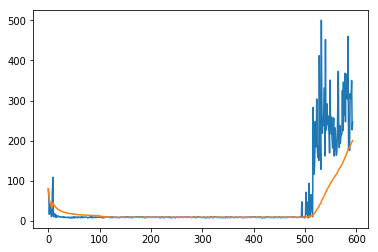

In [4]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(moving_scores)

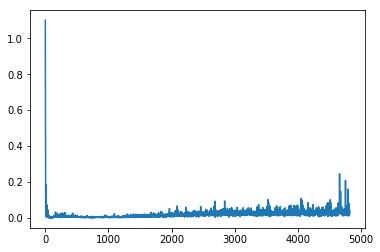

In [5]:
plt.plot(a.losses)

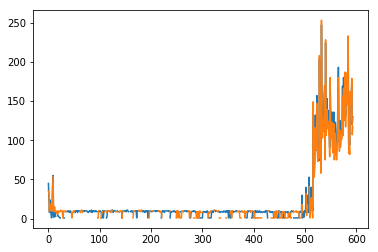

In [6]:
action_df = pd.DataFrame(action_df)
for i in action_df.columns:
    plt.plot(action_df[i])

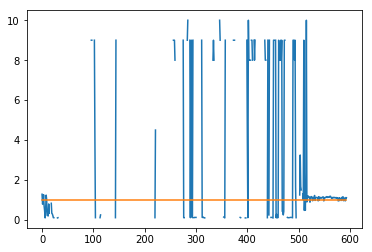

In [7]:
plt.plot(action_df[0]/action_df[1])
plt.plot([1 for i in range(action_df.shape[0])])

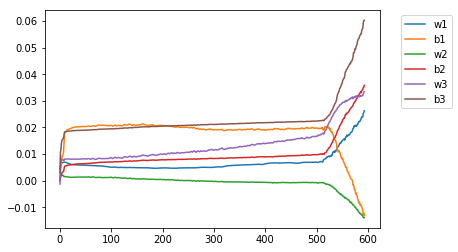

In [8]:
weight_df = pd.DataFrame(weight_df)
weight_df.columns = [str(i.shape) for i in a.network_local.get_weights()]
weight_df.columns = ['w1','b1','w2','b2','w3','b3']
for i in range(weight_df.shape[1]):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)